# Chapter 4 - Evaluation and Optimization

In [1]:
%pylab inline
import pandas as pandas

Populating the interactive namespace from numpy and matplotlib


We generate two inputs:
* features – a matrix of input features
* target – an array of target variables corresponding to those features

In [2]:
features = rand(100,5)
target = rand(100) > 0.5

### The holdout method

We divide into a randomized training and test set:

In [3]:
int(floor(0.7*100))

70

In [4]:
N = features.shape[0]
N_train = int(floor(0.7 * N))

# Randomize index
# Note: sometimes you want to retain the order in the dataset and skip this step
# E.g. in the case of time-based datasets where you want to test on 'later' instances
idx = random.permutation(N)

# Split index
idx_train = idx[:N_train]
idx_test = idx[N_train:]

# Break your data into training and testing subsets
features_train = features[idx_train,:]
target_train = target[idx_train]
features_test = features[idx_test,:]
target_test = target[idx_test]

# Build, predict, evaluate (to be filled out)
# model = train(features_train, target_train)
# preds_test = predict(model, features_test)
# accuracy = evaluate_acc(preds_test, target_test)

In [5]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(70, 5)
(30, 5)
(70,)
(30,)


### K-fold cross-validation

In [6]:
N = features.shape[0]
K = 10 # number of folds

preds_kfold = np.empty(N)
folds = np.random.randint(0, K, size=N)
print(folds)
for idx in np.arange(K):

    # For each fold, break your data into training and testing subsets
    features_train = features[folds != idx,:]
    target_train = target[folds != idx]
    features_test = features[folds == idx,:]
    
    # Print the indices in each fold, for inspection
    print("Positions of "+str(idx)+" in fold array: ", end="")
    print(nonzero(folds == idx)[0])

    # Build and predict for CV fold (to be filled out)
    # model = train(features_train, target_train)
    # preds_kfold[folds == idx] = predict(model, features_test)
    
# accuracy = evaluate_acc(preds_kfold, target)

[0 5 5 9 0 0 8 1 0 2 6 2 4 8 6 0 9 7 8 2 8 6 1 7 6 6 9 3 6 0 0 8 9 2 5 8 8
 4 6 7 5 9 2 9 6 1 0 3 1 4 8 2 6 7 3 3 3 6 8 6 7 1 5 4 2 5 1 4 6 0 6 8 9 1
 5 9 2 9 6 2 7 2 0 1 3 1 5 4 8 3 9 5 9 4 6 1 1 7 3 2]
Positions of 0 in fold array: [ 0  4  5  8 15 29 30 46 69 82]
Positions of 1 in fold array: [ 7 22 45 48 61 66 73 83 85 95 96]
Positions of 2 in fold array: [ 9 11 19 33 42 51 64 76 79 81 99]
Positions of 3 in fold array: [27 47 54 55 56 84 89 98]
Positions of 4 in fold array: [12 37 49 63 67 87 93]
Positions of 5 in fold array: [ 1  2 34 40 62 65 74 86 91]
Positions of 6 in fold array: [10 14 21 24 25 28 38 44 52 57 59 68 70 78 94]
Positions of 7 in fold array: [17 23 39 53 60 80 97]
Positions of 8 in fold array: [ 6 13 18 20 31 35 36 50 58 71 88]
Positions of 9 in fold array: [ 3 16 26 32 41 43 72 75 77 90 92]


### The ROC curve

In [35]:
def roc_curve(true_labels, predicted_probs, n_points=100, pos_class=1):
    thr = linspace(0,1,n_points)
    tpr = zeros(n_points)
    fpr = zeros(n_points)

    pos = true_labels == pos_class
    neg = logical_not(pos)
    n_pos = count_nonzero(pos)
    n_neg = count_nonzero(neg)
      
    for i,t in enumerate(thr):
        tpr[i] = count_nonzero(logical_and(predicted_probs >= t, pos)) / n_pos
        fpr[i] = count_nonzero(logical_and(predicted_probs >= t, neg)) / n_neg
    
    return fpr, tpr, thr


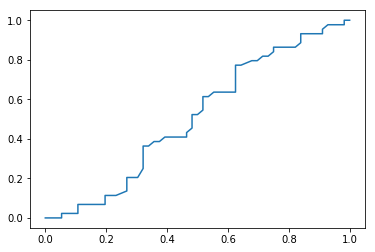

In [36]:
# Randomly generated predictions should give us a diagonal ROC curve
preds = rand(len(target))
fpr, tpr, thr = roc_curve(target, preds, pos_class=True)
plot(fpr, tpr)

### The area under the ROC curve

In [37]:
def auc(true_labels, predicted_labels, pos_class=1):
    fpr, tpr, thr = roc_curve(true_labels, predicted_labels,
 pos_class=pos_class)
    area = -trapz(tpr, x=fpr)
    return area

In [38]:
auc(target, preds, pos_class=True)

0.5091314935064936

### Multi-class classification

In [40]:
d = pandas.read_csv("data/mnist_small.csv")
d_train = d[:int(0.8*len(d))]
d_test = d[int(0.8*len(d)):]

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(d_train.drop('label', axis=1), d_train['label'])

C:\Users\thimo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
from sklearn.metrics import confusion_matrix
preds = rf.predict(d_test.drop('label', axis=1))
cm = confusion_matrix(d_test['label'], preds)

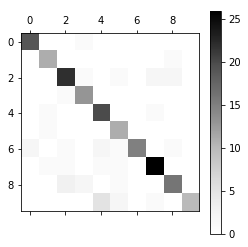

In [43]:
matshow(cm, cmap='Greys')
colorbar()
savefig("figures/figure-4.19.eps", format='eps')

### The root-mean-square error

In [44]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
    return np.sqrt(residuals/n)

In [46]:
rmse(rand(10), rand(10))

0.45249843652505634

### The R-squared error

In [47]:
def r2(true_values, predicted_values):
    n = len(true_values)
    mean = np.mean(true_values)
    residuals = 0
    total = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
        total += (true_values[i] - mean)**2.
    return 1.0 - residuals/total

In [48]:
r2(arange(10)+rand(), arange(10)+rand(10))

0.9914064605577929

### Grid search with kernel-SVM model

Importing modules:

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

Loading data and performang poor-mans feature engineering:

In [8]:
d = pandas.read_csv("data/titanic.csv")

# Target
y = d["Survived"]

# Features
X = d.drop(["Survived", "PassengerId", "Cabin","Ticket","Name", "Fare"], axis=1)
X['Sex'] = list(map(lambda x: 1 if x=="male" else 0, X['Sex']))
X['Embarked-Q'] = list(map(lambda x: 1 if x=="Q" else 0, X['Embarked']))
X['Embarked-C'] = list(map(lambda x: 1 if x=="C" else 0, X['Embarked']))
X['Embarked-S'] = list(map(lambda x: 1 if x=="S" else 0, X['Embarked']))
X = X.drop(["Embarked", "Sex"], axis=1)
X = X.fillna(-1)

Performing grid-search to find the optimal hyper-parameters:

In [9]:
# grid of (gamma, C) values to try 
gam_vec, cost_vec = np.meshgrid(np.logspace(0.01, 0.1, 11),
                     np.linspace(1, 5, 10))

AUC_all = [] # initialize empty array to store AUC results

# set up cross-validation folds
N = len(y)
K = 10 # number of cross-validation folds
folds = np.random.randint(0, K, size=N)

# search over every value of the grid
for param_ind in np.arange(len(gam_vec.ravel())):

    # initialize cross-validation predictions
    y_cv_pred = np.empty(N)

    # loop through the cross-validation folds
    for ii in np.arange(K):
        # break your data into training and testing subsets
        # X_train = X.ix[folds != ii,:]
        # y_train = y.ix[folds != ii]
        # X_test = X.ix[folds == ii,:]
        X_train = X.iloc[folds != ii,:]
        y_train = y.iloc[folds != ii]
        X_test = X.iloc[folds == ii,:]
        #X_train = X.iloc[folds, :]
        #X_train = X_train.drop(ii)
        #y_train = y.iloc[folds]
        #y_train = y.drop(ii)
        #X_test = X.iloc[folds, :]
        #X_test = X_test[folds == ii]
        
        # build a model on the training set
        model = SVC(gamma=gam_vec.ravel()[param_ind], C=cost_vec.ravel()[param_ind])
        model.fit(X_train, y_train)

        # generate and store model predictions on the testing set
        y_cv_pred[folds == ii] = model.predict(X_test)

    # evaluate the AUC of the predictions
    AUC_all.append(roc_auc_score(y, y_cv_pred))

indmax = np.argmax(AUC_all)
print("Maximum = %.3f" % (np.max(AUC_all)))
print("Tuning Parameters: (gamma = %.2f, C = %.2f)" % (gam_vec.ravel()[indmax], cost_vec.ravel()[indmax]))

Maximum = 0.639
Tuning Parameters: (gamma = 1.02, C = 3.67)


In [10]:
ix=2
print(folds)
# Train subset taking all rows except the ones with index == to the positions of ix in the folds array
X_train = X.iloc[folds!=ix,:]
print(X_train.head(20))
X_test = X.iloc[folds==ix,:]
print(X_test.head(20))

[4 3 4 5 3 9 4 0 8 4 6 0 3 7 5 3 2 0 5 3 7 9 2 0 8 4 8 2 0 6 8 9 8 4 1 2 6
 3 8 3 1 0 3 3 9 7 6 8 0 6 5 0 3 1 2 2 9 6 1 0 2 3 5 6 5 7 1 1 7 0 4 0 6 8
 7 9 6 4 7 4 0 1 2 9 5 8 7 5 2 5 6 1 5 3 6 0 0 8 2 0 8 8 6 2 1 3 2 0 2 1 5
 1 6 9 9 0 0 5 9 1 9 5 2 0 2 9 5 8 1 5 2 3 6 4 0 9 9 6 6 4 5 5 4 9 5 4 3 2
 7 2 6 7 9 1 7 7 1 8 8 3 2 5 3 4 3 0 5 8 6 5 9 1 5 3 1 6 1 7 0 1 7 7 9 3 7
 8 9 6 1 8 8 3 1 9 0 9 1 8 7 8 9 4 4 3 4 5 6 2 4 8 7 5 6 2 7 8 5 4 8 2 1 3
 1 6 7 5 1 2 0 0 2 6 3 3 5 0 5 5 5 5 1 5 4 2 1 9 3 6 1 2 0 4 4 5 4 2 6 5 4
 1 4 6 3 2 5 8 3 9 0 6 6 3 3 0 9 6 2 3 1 4 1 9 1 6 9 2 2 0 5 4 8 8 4 7 4 5
 1 0 7 4 7 0 8 0 4 7 2 6 1 0 3 4 2 3 0 3 6 9 8 3 6 5 2 7 3 6 4 4 2 3 0 5 9
 7 0 8 6 2 5 9 3 3 8 5 2 7 4 0 6 6 0 1 8 7 8 9 1 9 1 2 8 5 4 6 7 9 9 0 8 6
 8 9 6 0 8 1 7 8 2 5 0 3 1 7 4 7 6 4 7 2 2 3 5 0 0 5 2 1 4 5 1 5 3 7 2 3 4
 9 0 1 0 0 0 2 1 8 1 9 2 5 8 5 8 1 9 7 2 2 5 2 4 6 3 0 1 0 1 0 3 9 1 0 4 4
 2 7 9 8 2 4 9 4 3 6 7 1 3 5 8 1 8 3 2 4 8 6 0 5 4 4 2 8 6 7 6 3 5 3 9 3 2
 7 0 6 2 3 3 1 2 9 8 9 8 

Plotting the contours of the parameter performance:

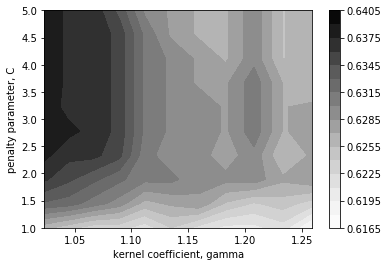

In [11]:
AUC_grid = np.array(AUC_all).reshape(gam_vec.shape)

contourf(gam_vec, cost_vec, AUC_grid, 20, cmap='Greys')
xlabel("kernel coefficient, gamma")
ylabel("penalty parameter, C")
colorbar()
savefig("figures/figure-4.25.eps", format='eps')